<a href="https://colab.research.google.com/github/shairatabassum/MachineLearning_python/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Random Forest Algorithm**

Random Forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions. The main idea of Random Forest algorithm is to combine multiple tress into a forest. So, we train multiple trees, each tree can be considered as a decision tree. All of the trees will get random subset of the training samples and each tree will make individual predictions. Then, the **Majority Voting** will be used for making the final prediction.

Random Forest is a powerful algorithm for several reasons:
* As it creates more trees, it gets more chances to make the correct prediction.
* It reduces the chances of overfitting with a single tree.
* As it combines multiple trees, the accuracy is always higher than single tree predictions.

### **Import Dataset**

In [21]:
# import libraries
import numpy as np
from collections import Counter
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
# load breast cancer dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# print data samples
print('X: ', X_train.shape)
print('Sample of X:', X_train[0])
print('y: ', y_train.shape)
print('Sample of y:', y_train[0])

X:  (455, 30)
Sample of X: [1.288e+01 1.822e+01 8.445e+01 4.931e+02 1.218e-01 1.661e-01 4.825e-02
 5.303e-02 1.709e-01 7.253e-02 4.426e-01 1.169e+00 3.176e+00 3.437e+01
 5.273e-03 2.329e-02 1.405e-02 1.244e-02 1.816e-02 3.299e-03 1.505e+01
 2.437e+01 9.931e+01 6.747e+02 1.456e-01 2.961e-01 1.246e-01 1.096e-01
 2.582e-01 8.893e-02]
y:  (455,)
Sample of y: 1


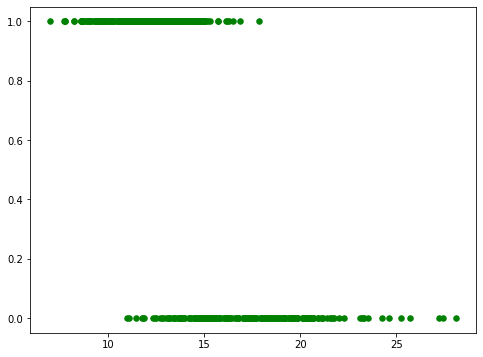

In [3]:
# plot data samples
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], y, color='g', s=30)
plt.show()

### **Random Forest from scratch**

In [13]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]


def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [5]:
class DecisionTreeModel:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [9]:
class RandomForestModel:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeModel(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats,
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [17]:
# train the model
clf = RandomForestModel(n_trees=3, max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# model accuracy
accuracy = np.sum(y_test == predictions) / len(y_test)
print('Accuracy', round(accuracy*100, 2), '%')

Accuracy 94.74 %


In [18]:
# classification report
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       212
           1       0.98      0.99      0.98       357

    accuracy                           0.98       569
   macro avg       0.98      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569



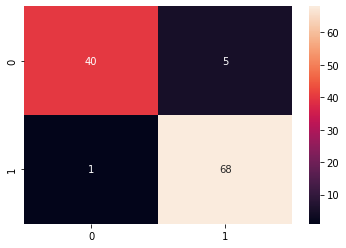

In [19]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, predictions), annot=True)

### **Random Forest using scikit-learn**

In [30]:
# train the model
rf = RandomForestClassifier(n_estimators=1000, random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# model accuracy
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy = accuracy*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.98 %.


In [31]:
# classification report
print(classification_report(y, rf.predict(X)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       212
           1       0.98      1.00      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.98      0.98       569
weighted avg       0.99      0.99      0.99       569



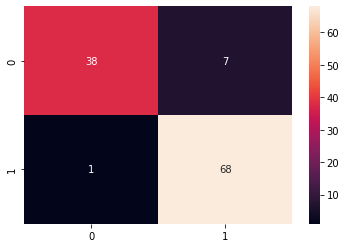

In [32]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)